In [51]:
import numpy as np
import pandas as pd
import volpriceinference as vl
# import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys
from functools import partial
import cdpm
from functools import partial

In [52]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [53]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

## Setup the True Parameters /  Simulation Parameters

In [54]:
kharpov = True

In [58]:
if kharpov:
    true_params = {'theta': 1.7680, 
               'pi': -10,
               'phi': -.4,
               'scale': 252 * 1.564e-5,
               'delta': 0.6475,
               'rho': .95,
              }
else:
     true_params ={'delta': 0.27,
                   'rho': 0.81,
                   'scale': 3.11,
                   'phi': -.1,
                   'pi': -.2,
                   'theta': .53}
    
time_dim = 3700
sim_dim = 500
innov_dim = 250

In [59]:
vl.__version__

'0.0.13-py36_0'

In [60]:
total_true_params = true_params.copy()
total_true_params.update(
    {'gamma': vl.compute_gamma(**true_params),
     'beta':vl.compute_beta(rho=true_params['rho'], scale=true_params['scale'], phi=true_params['phi'], 
                    pi=true_params['pi'], theta=true_params['theta']),
     'psi':vl.compute_psi(rho=true_params['rho'], scale=true_params['scale'], phi=true_params['phi'], 
                  theta=true_params['theta']),
      'zeta': 1 - true_params['phi']**2})

In [61]:
def compute_moments(delta, rho, scale, phi, pi, theta):
    
    vol_mean = scale * delta / (1 - rho)
    vol_var = (2 * scale * rho * vol_mean + scale**2 * delta) / (1 - rho**2)
    
    psi = vl.compute_psi(rho=rho, scale=scale, phi=phi, theta=theta)
    beta = vl.compute_beta(rho=rho, scale=scale, phi=phi, pi=pi, theta=theta)
    gamma = vl.compute_gamma(delta=delta, rho=rho, scale=scale, phi=phi, pi=pi, theta=theta)
    
    return_mean = psi * vol_mean + beta * vol_mean + gamma
    return_var = psi**2 * vol_var + beta**2 * vol_var  + (1 - phi**2) * vol_mean
    
    return {'return_mean': return_mean, 'return_var': return_var, 'vol_mean': vol_mean, 'vol_var': vol_var}

In [62]:
compute_moments(**true_params)

{'return_mean': -0.0219985208712088,
 'return_var': 0.2689966896570579,
 'vol_mean': 0.051039575999999955,
 'vol_var': 0.004023225201945595}

In [63]:
vl.compute_gamma(**true_params)

0.01244667764282458

In [64]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'scale': 0.00394128,
 'delta': 0.6475,
 'rho': 0.95,
 'gamma': 0.01244667764282458,
 'beta': 4.952969990414809,
 'psi': -5.627842338767261,
 'zeta': 0.84}

In [12]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'scale': 0.00394128,
 'delta': 0.6475,
 'rho': 0.95}

In [13]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'scale': 0.00394128,
 'delta': 0.6475,
 'rho': 0.95,
 'gamma': 0.01244667764282458,
 'beta': 4.952969990414809,
 'psi': -5.627842338767261,
 'zeta': 0.84}

## We start by examining the distributions of simulated data

In [14]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

In [15]:
data.corr()

,vol,rtn
vol,1.00000,-0.25315
rtn,-0.25315,1.00000


In [16]:
omega, omega_cov = vl.estimate_params(data)

In [17]:
omega

{'gamma': 0.01130889355724171,
 'beta': 5.164204334420921,
 'psi': -5.850504836766171,
 'zeta': 0.8583603939715888,
 'delta': 0.6333936420570774,
 'rho': 0.9432636806643706,
 'scale': 0.003931308070956541}

In [18]:
omega_cov

,beta,delta,gamma,psi,rho,scale,zeta
beta,0.010410,0.000000e+00,-3.212938e-05,-0.009685,0.000000e+00,0.000000e+00,0.000000
delta,0.000000,3.117497e-03,0.000000e+00,0.000000,-2.631209e-04,-3.497372e-07,0.000000
gamma,-0.000032,0.000000e+00,3.261474e-07,0.000025,0.000000e+00,0.000000e+00,0.000000
psi,-0.009685,0.000000e+00,2.475186e-05,0.014382,0.000000e+00,0.000000e+00,0.000000
rho,0.000000,-2.631209e-04,0.000000e+00,0.000000,7.322714e-05,-2.435171e-07,0.000000
scale,0.000000,-3.497372e-07,0.000000e+00,0.000000,-2.435171e-07,1.837383e-08,0.000000
zeta,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000381


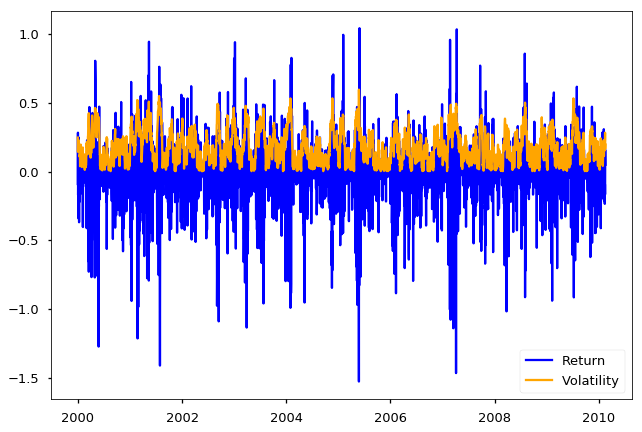

In [19]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return', color='blue')
ax1.plot(data.vol.apply(np.sqrt), label='Volatility', color='orange')

ax1.legend()

In [20]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,vol,rtn
vol,0.013149,-0.006130
rtn,-0.006130,0.053259


In [21]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'scale': 0.00394128,
 'delta': 0.6475,
 'rho': 0.95,
 'gamma': 0.01244667764282458,
 'beta': 4.952969990414809,
 'psi': -5.627842338767261,
 'zeta': 0.84}

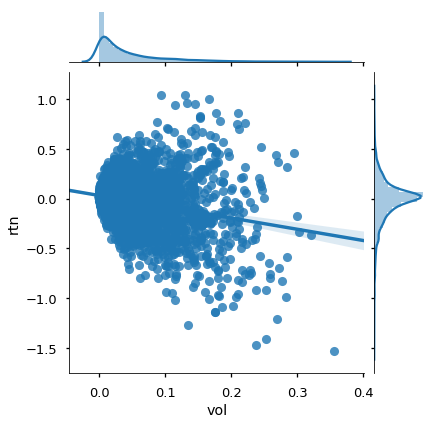

In [22]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [23]:
data.describe()

,vol,rtn
count,3700.000000,3700.000000
mean,0.044186,-0.019001
std,0.051667,0.230779
min,0.000010,-1.529003
25%,0.007138,-0.109682
50%,0.024463,0.005796
75%,0.061693,0.084520
max,0.356124,1.044200


## I now estimate all of the parameters

In [24]:
data_arr = [vl.simulate_data(time_dim=time_dim, **true_params)  for _ in tqdm.tnrange(sim_dim)]

In [25]:
estimator = partial(vl.estimate_params_strong_id, case=1)

In [26]:
estimator(data_arr[2])

({'gamma': 0.012172614817351674,
  'beta': 5.139350464769456,
  'psi': -5.831760346111181,
  'zeta': 0.8517437736043444,
  'delta': 0.7397691352034458,
  'rho': 0.9513538773017666,
  'scale': 0.004008006009647012,
  'phi': -0.3758768035833812,
  'pi': -17.599164072554462,
  'theta': 2.2775899208398633},
            beta         delta         gamma       phi         pi       psi  \
 beta   0.018477  0.000000e+00 -3.715748e-05       NaN        NaN -0.017875   
 delta  0.000000  4.651620e-03  0.000000e+00       NaN        NaN  0.000000   
 gamma -0.000037  0.000000e+00  4.117186e-07       NaN        NaN  0.000030   
 phi         NaN           NaN           NaN  0.000648  -0.161175       NaN   
 pi          NaN           NaN           NaN -0.161175  45.702880       NaN   
 psi   -0.017875  0.000000e+00  3.045640e-05       NaN        NaN  0.021136   
 rho    0.000000 -2.635819e-04  0.000000e+00       NaN        NaN  0.000000   
 scale  0.000000 -7.306131e-07  0.000000e+00       NaN        N

In [27]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(estimator, data_arr),
                                      total=len(data_arr)))

In [28]:
def t_stats(x):
    mean = x.mean()
    cov = x.cov()
        
    return mean  / np.sqrt(np.diag(cov) / data.vol.size)

In [29]:
moment_data = pd.DataFrame([t_stats(vl.vol_moments(data.vol, delta=true_params['delta'],
                                                   rho=true_params['rho'], scale=true_params['scale'])) 
                            for data in tqdm.tqdm_notebook(data_arr)])

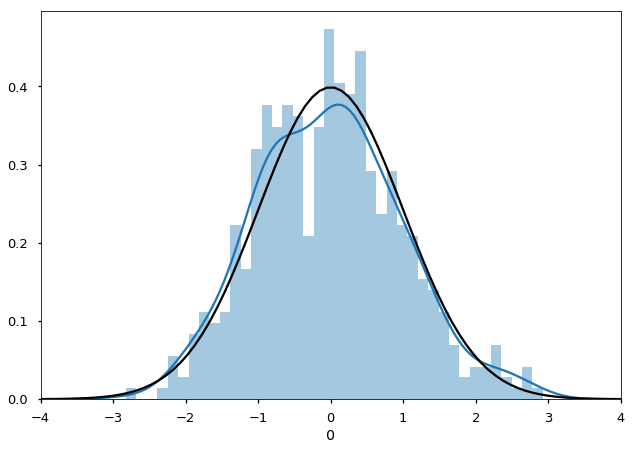

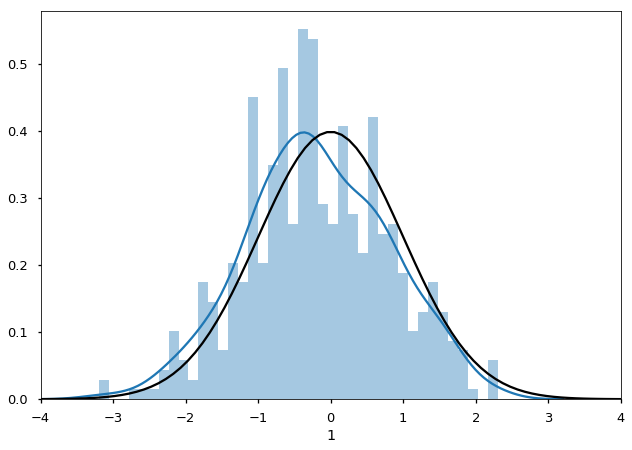

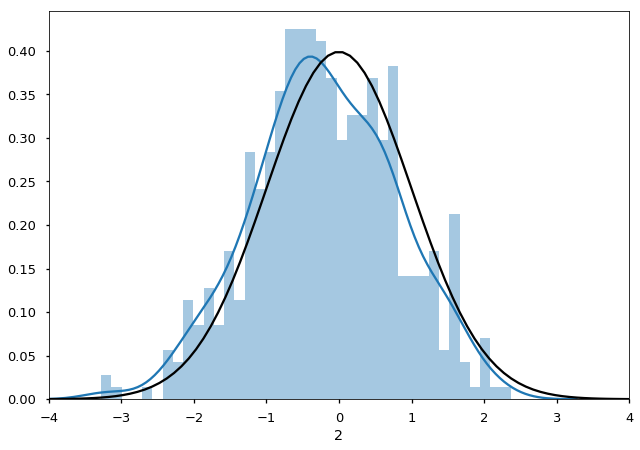

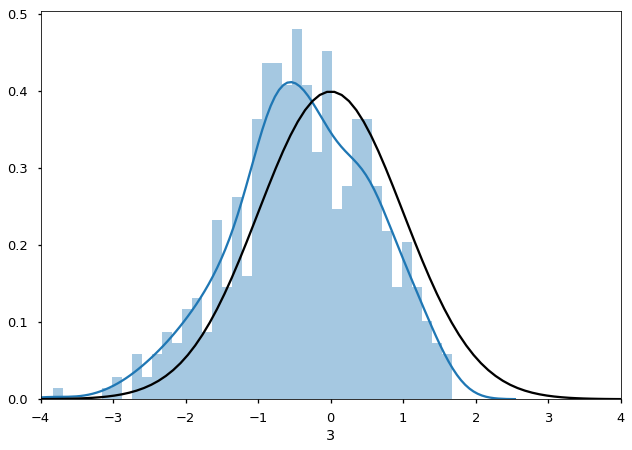

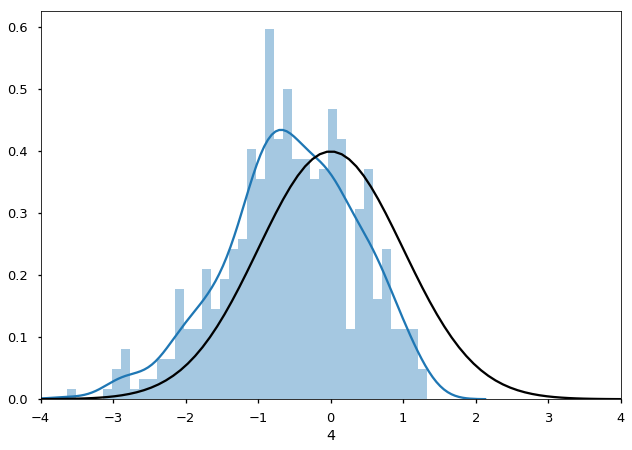

In [30]:
for name, moment in moment_data.items():
    moment_fig, moment_ax = mpl.pyplot.subplots()
    sns.distplot(moment, ax=moment_ax, bins=40)
    moment_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
    moment_ax.set_xlim([-4,4])

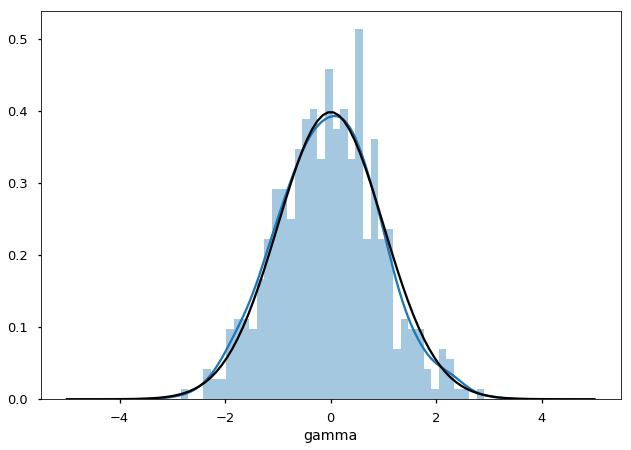

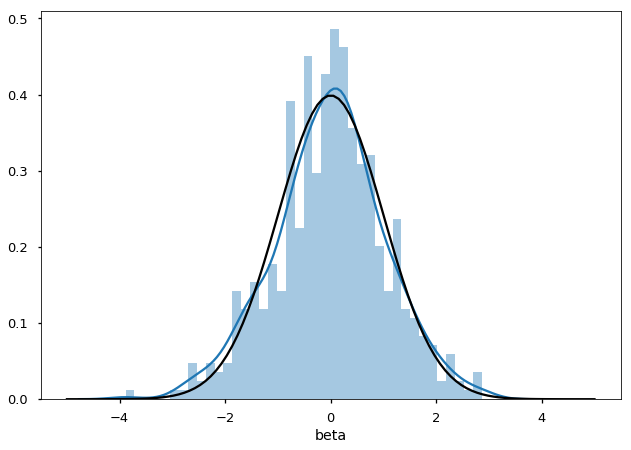

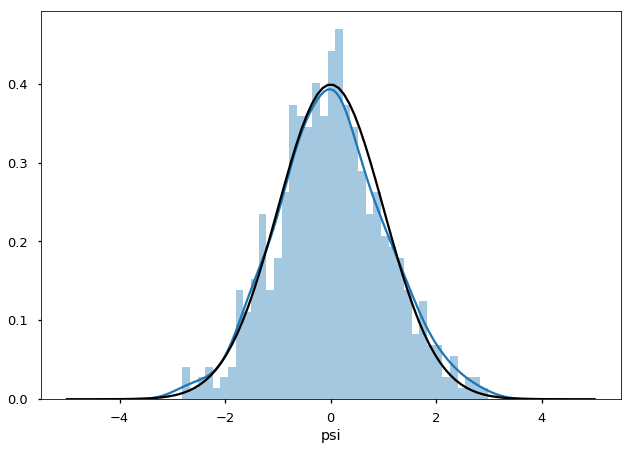

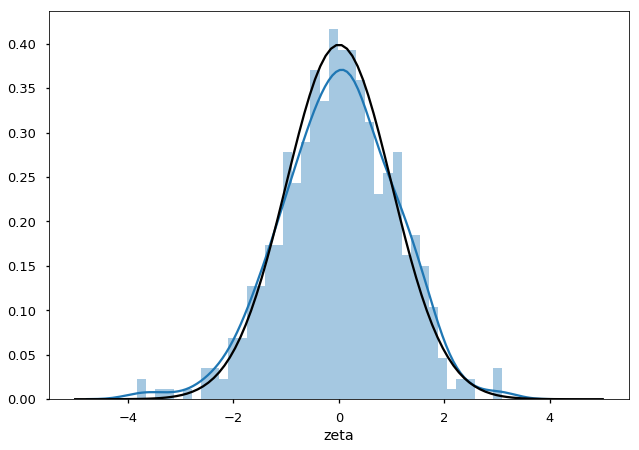

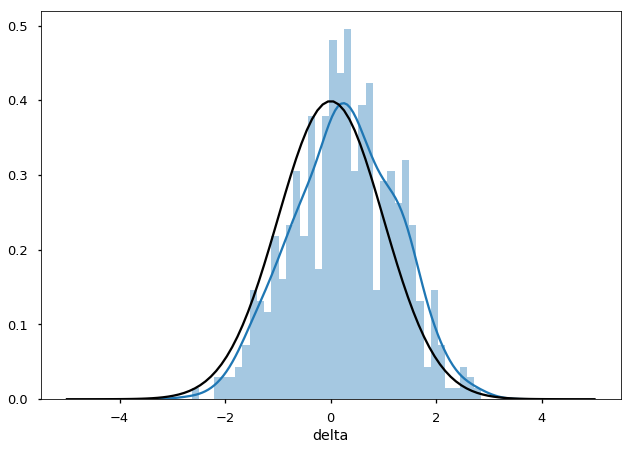

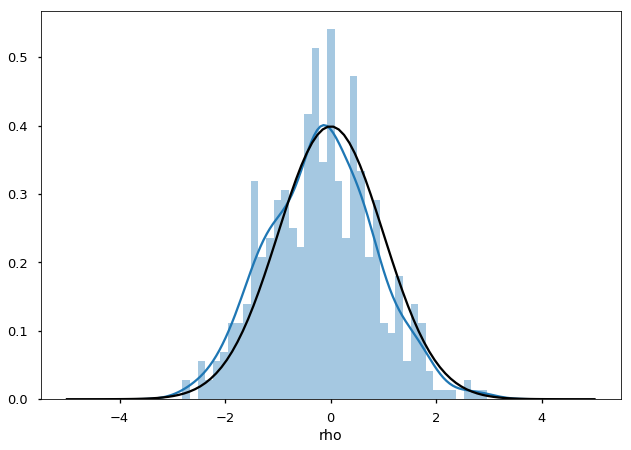

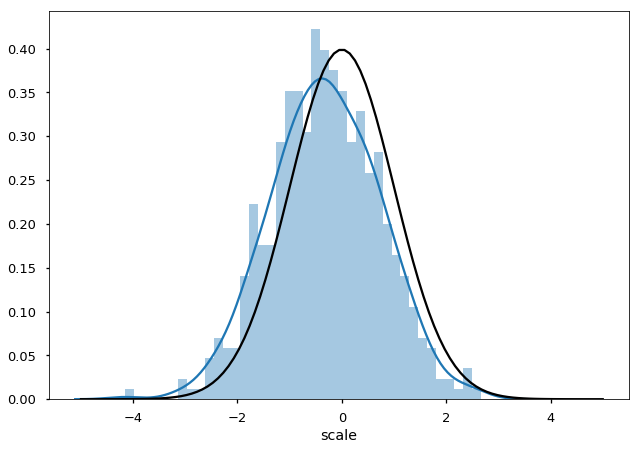

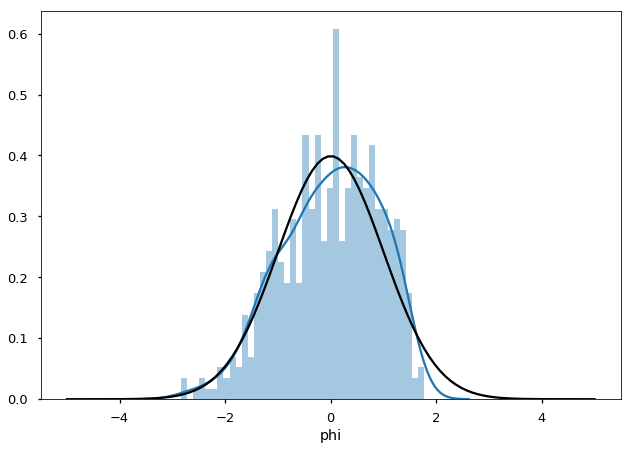

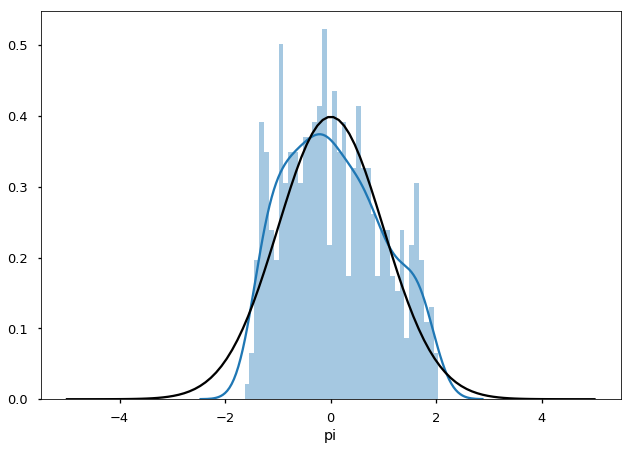

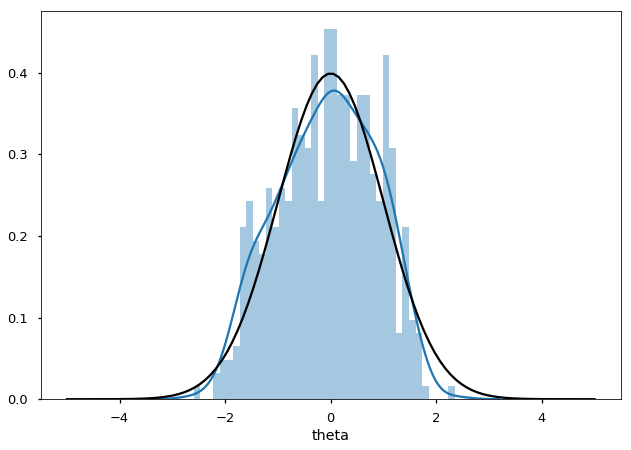

In [31]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in est_arr[0][0].keys():
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([(est[name] - total_true_params[name]) / np.sqrt(cov.loc[name,name])
                  for est, cov in est_arr]).dropna(), ax=ax, bins=40)
        ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
        ax.set_xlabel(name)
        if max(ax.get_xlim()) > 20:
            ax.set_xlim(-20, 20)

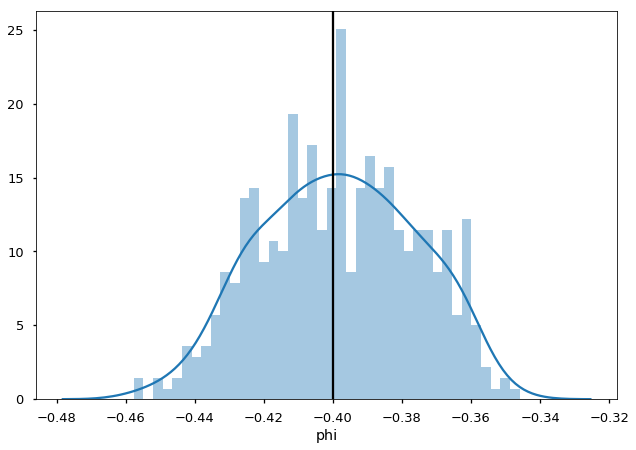

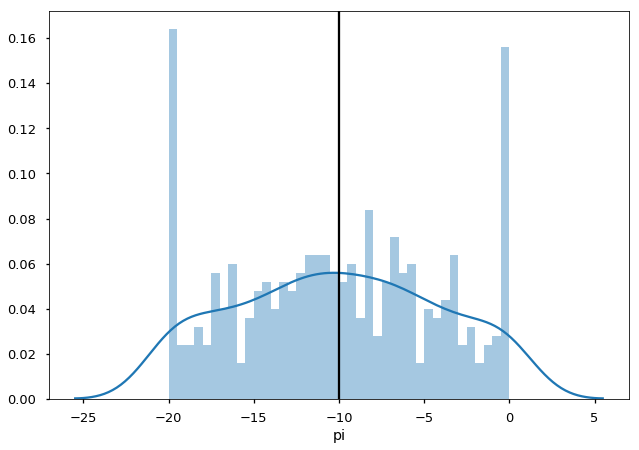

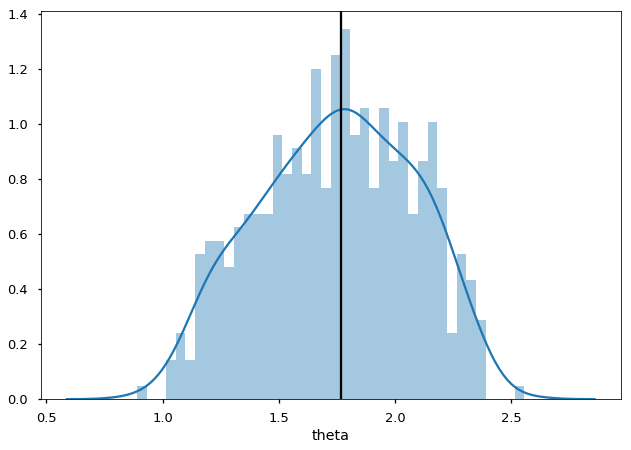

In [32]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in ['phi', 'pi', 'theta']:
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([est[name] for est, cov in est_arr]).dropna(), ax=ax, bins=40)
        ax.set_xlabel(name)
        ax.axvline(total_true_params[name], color='black')
        if max(ax.get_xlim()) > 20:
            ax.set_xlim(-20, 20)

# I now compute the robust conditional QLR statistic 

In [33]:
omega


{'gamma': 0.01130889355724171,
 'beta': 5.164204334420921,
 'psi': -5.850504836766171,
 'zeta': 0.8583603939715888,
 'delta': 0.6333936420570774,
 'rho': 0.9432636806643706,
 'scale': 0.003931308070956541}

In [34]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'scale': 0.00394128,
 'delta': 0.6475,
 'rho': 0.95}

In [35]:
compute_vals = partial(vl.compute_qlr_reject, true_prices=[true_params['phi'], true_params['pi'], 
                                                           true_params['theta']],
                      innov_dim=50, alpha=None, robust_quantile=True)

In [36]:
# total=min(50, len(est_arr))
# with Pool(8) as pool:
#     results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_vals, 
#                                                                                     est_arr[:total]),
#                                                           total=total))))

In [37]:
# results[results <=0] = 0 

In [38]:
# robust_pit = cdpm.probability_integral_transform(evaluated_data = results.iloc[:,0].to_frame(),
#                                     reference_data=results.iloc[:,1:]).replace(np.inf, 1)

In [39]:
# standard_pit = stats.chi2.cdf(results.iloc[:,0], df=3)

In [40]:
# fig, ax = mpl.pyplot.subplots()
# cdpm.pit_plot(standard_pit, ax=ax, color='orange', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
#               label='standard')
# cdpm.pit_plot(robust_pit, ax=ax, color='blue', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
#               label='robust')
# ax.legend()
# fig.savefig('../doc/figures/asymptotic_dist_pitop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
#             frameon=False, pad_inches=0, bbox_inches='tight', transparent=True)

In [41]:
returnval = vl.compute_robust_rejection(est_arr, true_params, innov_dim=innov_dim, alpha=0.05, case=1,
                                        robust_quantile=True)

In [42]:
returnval.head()

,qlr_stat,robust_qlr_qauntile,robust,standard
0,2.455064,7.736175,False,False
1,1.723430,7.780664,False,False
2,2.647487,7.838265,False,False
3,3.970464,7.874201,False,False
4,0.365961,7.822413,False,False


In [43]:
returnval.head()

,qlr_stat,robust_qlr_qauntile,robust,standard
0,2.455064,7.736175,False,False
1,1.723430,7.780664,False,False
2,2.647487,7.838265,False,False
3,3.970464,7.874201,False,False
4,0.365961,7.822413,False,False


In [44]:
returnval.mean()

qlr_stat               3.179932
robust_qlr_qauntile    7.357117
robust                 0.076000
standard               0.062000
dtype: float64

In [45]:
true_params['phi']

-0.4

In [46]:
if kharpov:
    filename = '../results/reject_prop_kharpov_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], 
                                                                         time_dim)
else:
    filename = '../results/reject_prop_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], 
                                                                         time_dim)
    
returnval.to_json(filename)

In [ ]:
innov_dim

In [50]:
returnval.mean()

qlr_stat               3.179932
robust_qlr_qauntile    7.357117
robust                 0.076000
standard               0.062000
dtype: float64

In [48]:
returnval.query('robust_qlr_qauntile > 0').mean()

qlr_stat               3.179932
robust_qlr_qauntile    7.357117
robust                 0.076000
standard               0.062000
dtype: float64

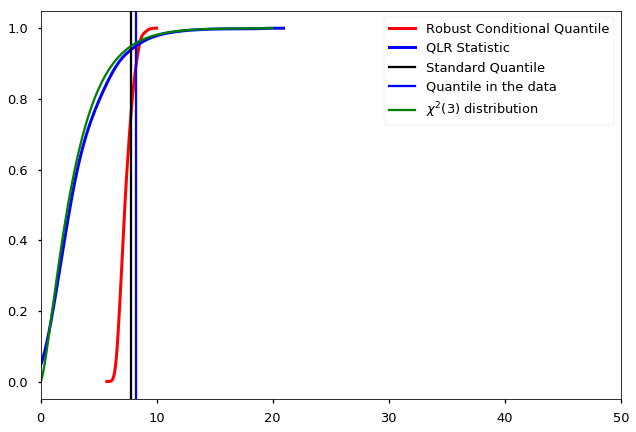

In [49]:
fig4, ax4 = mpl.pyplot.subplots()
try:
    sns.distplot(returnval.query('robust_qlr_qauntile > 0').robust_qlr_qauntile, 
                 kde_kws={"color": "red", "lw": 3, 'cumulative':True}, ax=ax4,hist=False, 
                 label='Robust Conditional Quantile')
           
except AttributeError:
    pass

sns.distplot(returnval.qlr_stat, hist=False, ax=ax4,kde_kws={"color": "blue", "lw": 3, 'cumulative':True},
      label='QLR Statistic')
ax4.axvline(stats.chi2.ppf(.95, df=3), color='black', label='Standard Quantile')
ax4.axvline(np.percentile(returnval.qlr_stat, 95),  color='Blue', label='Quantile in the data')

xvals = np.linspace(0, 20, 500)
ax4.plot(xvals, [stats.chi2.cdf(x, df=3) for x in xvals], color='green', label='$\chi^2(3)$ distribution')
ax4.set_xlim([0,50])
# ax4.set_ylim([0,.5])
ax4.set_xlabel("")
ax4.legend()
fig4.savefig('../doc/figures/reject_prop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
            frameon=False, pad_inches=0, bbox_inces='tight', transparent=True)